In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize NLTK components
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to manually undersample a dataset
def manual_undersample(X, y):
    """
    Manually undersample the majority classes to match the minority class.
    
    Args:
        X: Features
        y: Target labels
        
    Returns:
        X_resampled: Undersampled features
        y_resampled: Undersampled target labels
    """
    # Get class counts
    class_counts = Counter(y)
    print(f"Original class distribution: {class_counts}")
    
    # Identify the minority class
    minority_class = min(class_counts, key=class_counts.get)
    min_count = class_counts[minority_class]
    print(f"Minority class: {minority_class}, count: {min_count}")
    
    # Create a dataframe from X and y for easier manipulation
    df = pd.DataFrame({'X': X, 'y': y})
    
    # Initialize the resampled dataframe with all samples from the minority class
    resampled_df = df[df['y'] == minority_class]
    
    # Undersample each majority class
    for cls in class_counts:
        if cls != minority_class:
            # Get samples from the current majority class
            class_df = df[df['y'] == cls]
            
            # Sample the same number as the minority class
            if len(class_df) > min_count:
                sampled_df = class_df.sample(n=min_count, random_state=42)
                resampled_df = pd.concat([resampled_df, sampled_df])
            else:
                # If this class has fewer samples than the minority class, keep all
                resampled_df = pd.concat([resampled_df, class_df])
    
    # Shuffle the resampled dataframe
    resampled_df = resampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Print the new class distribution
    new_class_counts = Counter(resampled_df['y'])
    print(f"Resampled class distribution: {new_class_counts}")
    
    # Return the resampled X and y
    return resampled_df['X'], resampled_df['y']

# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print(f"Sentence Transformer model loaded successfully")

# Custom transformer for Sentence Transformer embeddings
# Fix the SentenceTransformerFeatures transformer
class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Convert to list if not already
        if isinstance(X, pd.Series):
            texts = X.tolist()
        elif isinstance(X, list):
            texts = X  # Already a list
        else:
            texts = [X]  # Single string
            
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            texts, 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings
# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_combined_classifier(train_file, test_file=None):
    """
    Train an English text classifier using SVM with combined Sentence Transformer 
    and Bag of Words features, applying manual undersampling to handle class imbalance.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the original class distribution
        print("\nOriginal training class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot original class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Original Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('original_training_class_distribution.png')
        print("Original class distribution plot saved as 'original_training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Apply manual undersampling to balance classes
        print("\nApplying manual undersampling to balance classes...")
        X_train_resampled, y_train_resampled = manual_undersample(X_train, y_train)
        
        # Print resampled class distribution
        print("\nResampled training class distribution:")
        resampled_class_dist = pd.Series(y_train_resampled).value_counts()
        print(resampled_class_dist)
        
        # Plot resampled class distribution
        resampled_df = pd.DataFrame({'label_class': y_train_resampled})
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=resampled_df)
        plt.title('Resampled Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('resampled_training_class_distribution.png')
        print("Resampled class distribution plot saved as 'resampled_training_class_distribution.png'")
        
        # Create feature union pipeline combining Sentence Transformers and Bag of Words
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...")
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('bag_of_words', Pipeline([
                ('vectorizer', CountVectorizer(
                    max_features=5000,
                    min_df=5,
                    max_df=0.7,
                    stop_words='english'
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=1.0,
                kernel='rbf',  # Radial basis function kernel
                gamma='scale',  # Scale gamma based on feature variance
                # No need for class_weight='balanced' anymore, since we're using undersampling
                probability=True,  # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model on the resampled data
        print("Training the model on resampled data (extracting combined features and fitting SVM)...")
        pipeline.fit(X_train_resampled, y_train_resampled)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(list(set(y_test))), yticklabels=sorted(list(set(y_test))))
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

import joblib

def save_model(model, model_path):
    """
    Save the trained model to disk.
    
    Args:
        model: Trained model pipeline
        model_path: Path to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully!")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model(model_path):
    """
    Load a trained model from disk.
    
    Args:
        model_path: Path to the saved model
        
    Returns:
        Loaded model
    """
    try:
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def predict_single_text(model, text):
    """
    Use a trained model to make a prediction on a single text input.
    
    Args:
        model: Trained classifier pipeline
        text: Text input string
        
    Returns:
        Dictionary containing prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_english_text(text)
        
        # Make prediction (pass as a list)
        prediction_class = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        max_prob = max(probabilities)
        
        # Convert string prediction back to float value
        prediction_value = float(prediction_class)
        
        # Return results
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'predicted_label_class': prediction_class,
            'predicted_label_value': prediction_value,
            'confidence': max_prob
        }
        
        print("\nResults:")
        print(f"Original text: {text}")
        print(f"Processed text: {processed_text}")
        print(f"Prediction (class): {prediction_class}")
        print(f"Prediction (value): {prediction_value}")
        print(f"Confidence: {max_prob:.4f}")
        
        return result
        
    except Exception as e:
        print(f"Error predicting single text: {e}")
        import traceback
        traceback.print_exc()
        return None

def interactive_inference(model):
    """
    Run an interactive session to get predictions on user-provided text.
    
    Args:
        model: Trained classifier pipeline
    """
    print("\n=== Interactive Text Classification ===")
    print("Enter text to classify (or 'q' to quit):")
    
    while True:
        text = input("\nText> ")
        
        if text.lower() == 'q':
            print("Exiting interactive mode.")
            break
            
        if not text.strip():
            print("Please enter some text.")
            continue
            
        result = predict_single_text(model, text)
        
        if result:
            print("\nResults:")
            print(f"Processed text: {result['processed_text']}")
            print(f"Prediction (class): {result['predicted_label_class']}")
            print(f"Prediction (value): {result['predicted_label_value']}")
            print(f"Confidence: {result['confidence']:.4f}")
        else:
            print("Failed to get prediction.")
def run_inference(model, input_source, output_file=None):
    """
    Unified function to run inference on either a file or a single text.
    
    Args:
        model: Trained classifier pipeline
        input_source: Path to CSV file or a single text string
        output_file: Path to save predictions if input is a file
        
    Returns:
        Results dataframe if input is a file, or prediction dict if input is text
    """
    # Check if input_source is a file path
    if os.path.exists(input_source) and input_source.endswith('.csv'):
        print(f"Input is a CSV file: {input_source}")
        return predict_on_new_data(model, input_source, output_file or "predictions.csv")
    else:
        # Treat input_source as a text string
        print("Input is a text string")
        return predict_single_text(model, input_source)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully



===== Text Classification Model =====
1. Train a new model
2. Load existing model (if available)


Enter your choice (1/2):  1



Training new model with data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv
Model will be saved to /kaggle/working/english_text_classifier_l1.joblib
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Original training class distribution:
label_class
0.0    5269
1.0    1262
Name: count, dtype: int64
Original class distribution plot saved as 'original_training_class_distribution.png'

Applying manual undersampling to balance classes...
Original class distribution: Counter({'0.0': 5269, '1.0': 1262})
Minority class: 1.0, count: 1262
Resampled class distribution: Counter({'0.0': 1262, '1.0': 1262})

Resampled training class distribution:
y
0.0    1262
1.0    1262
Name: count, dtype: int64
Resampled class distribution plot saved as 'resampled_training_class_distribution.png'

Creating feature pipeline with Sentence Transformer embeddings, Bag o

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv...
Preprocessing test text...
Calculating majority vote for test labels...
Making predictions on test data...


Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.7118

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.78      0.85       877
         1.0       0.47      0.74      0.58       230

    accuracy                           0.77      1107
   macro avg       0.70      0.76      0.71      1107
weighted avg       0.83      0.77      0.79      1107

Confusion matrix saved as 'confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'test_predictions.csv'
Saving model to /kaggle/working/english_text_classifier_l1.joblib...
Model saved successfully!

===== Inference Options =====
1. Classify a single text
2. Classify texts from a CSV file
3. Run interactive classification
4. Exit


KeyboardInterrupt: Interrupted by user

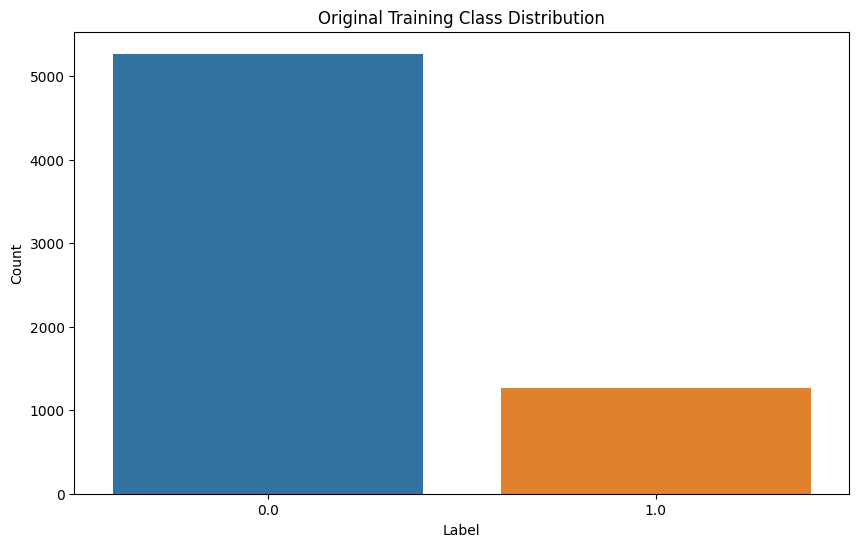

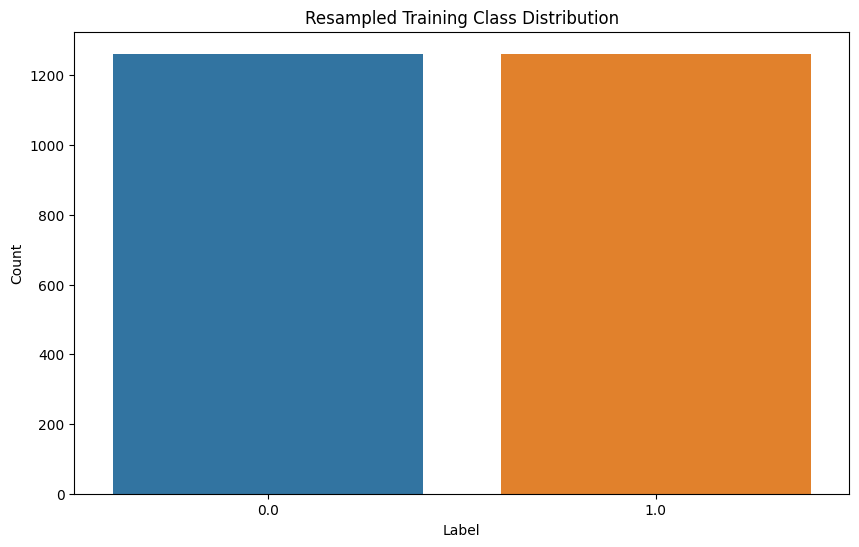

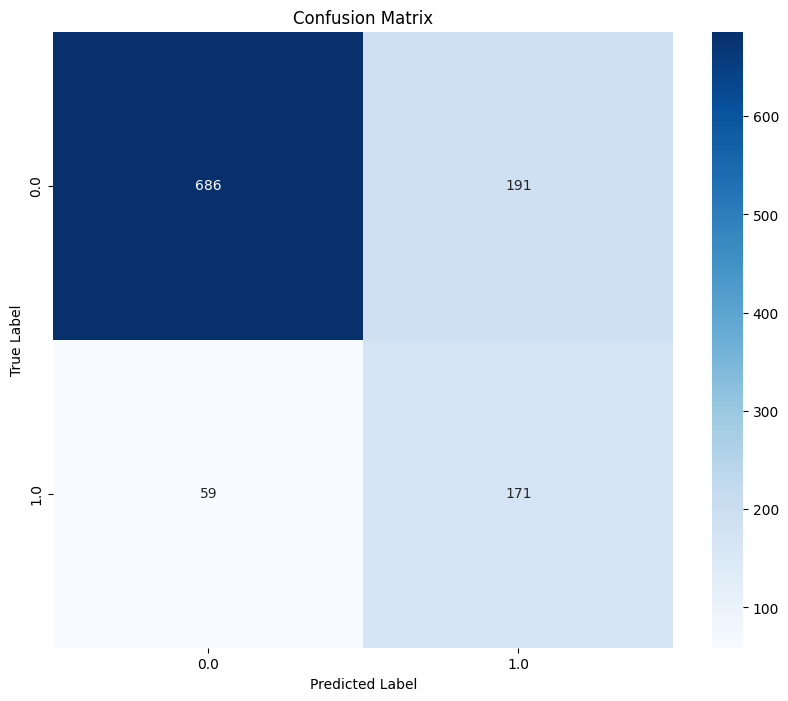

In [20]:
if __name__ == "__main__":
    import os
    
    # File paths for Kaggle notebook
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv"
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv"
    model_path = "/kaggle/working/english_text_classifier_l1.joblib"
    
    # Create simple menu-driven interface for Kaggle notebook
    print("\n===== Text Classification Model =====")
    print("1. Train a new model")
    print("2. Load existing model (if available)")
    choice = input("Enter your choice (1/2): ")
    
    model = None
    
    if choice == "1":
        print(f"\nTraining new model with data from {train_file}")
        print(f"Model will be saved to {model_path}")
        
        # Train and evaluate the model
        model, macro_f1, report = train_combined_classifier(train_file, test_file)
        
        # Save the model if training succeeded
        if model is not None:
            save_model(model, model_path)
    
    elif choice == "2":
        if os.path.exists(model_path):
            print(f"\nLoading existing model from {model_path}")
            model = load_model(model_path)
        else:
            print(f"\nNo existing model found at {model_path}")
            print("Please train a new model first.")
    
    # If we have a valid model, provide inference options
    if model is not None:
        while True:
            print("\n===== Inference Options =====")
            print("1. Classify a single text")
            print("2. Classify texts from a CSV file")
            print("3. Run interactive classification")
            print("4. Exit")
            
            inference_choice = input("\nEnter your choice (1/2/3/4): ")
            
            if inference_choice == "1":
                text = input("\nEnter text to classify: ")
                predict_single_text(model, text)
            
            elif inference_choice == "2":
                input_file = input("\nEnter path to input CSV file: ")
                output_file = input("Enter path for output file: ")
                
                # Use Kaggle paths if not specified
                if not input_file:
                    input_file = "/kaggle/input/your-test-dataset/test.csv"
                if not output_file:
                    output_file = "/kaggle/working/predictions.csv"
                
                print(f"\nClassifying texts from {input_file}")
                print(f"Results will be saved to {output_file}")
                predict_on_new_data(model, input_file, output_file)
            
            elif inference_choice == "3":
                interactive_inference(model)
            
            elif inference_choice == "4":
                print("\nExiting the program.")
                break
            
            else:
                print("\nInvalid choice. Please select a valid option.")
    
    print("\n===== End of Program =====")

In [16]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize NLTK components
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to manually undersample a dataset
def manual_undersample(X, y):
    """
    Manually undersample the majority classes to match the minority class.
    
    Args:
        X: Features
        y: Target labels
        
    Returns:
        X_resampled: Undersampled features
        y_resampled: Undersampled target labels
    """
    # Get class counts
    class_counts = Counter(y)
    print(f"Original class distribution: {class_counts}")
    
    # Identify the minority class
    minority_class = min(class_counts, key=class_counts.get)
    min_count = class_counts[minority_class]
    print(f"Minority class: {minority_class}, count: {min_count}")
    
    # Create a dataframe from X and y for easier manipulation
    df = pd.DataFrame({'X': X, 'y': y})
    
    # Initialize the resampled dataframe with all samples from the minority class
    resampled_df = df[df['y'] == minority_class]
    
    # Undersample each majority class
    for cls in class_counts:
        if cls != minority_class:
            # Get samples from the current majority class
            class_df = df[df['y'] == cls]
            
            # Sample the same number as the minority class
            if len(class_df) > min_count:
                sampled_df = class_df.sample(n=min_count, random_state=42)
                resampled_df = pd.concat([resampled_df, sampled_df])
            else:
                # If this class has fewer samples than the minority class, keep all
                resampled_df = pd.concat([resampled_df, class_df])
    
    # Shuffle the resampled dataframe
    resampled_df = resampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Print the new class distribution
    new_class_counts = Counter(resampled_df['y'])
    print(f"Resampled class distribution: {new_class_counts}")
    
    # Return the resampled X and y
    return resampled_df['X'], resampled_df['y']

# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print(f"Sentence Transformer model loaded successfully")

# Custom transformer for Sentence Transformer embeddings
# Fix the SentenceTransformerFeatures transformer
class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Convert to list if not already
        if isinstance(X, pd.Series):
            texts = X.tolist()
        elif isinstance(X, list):
            texts = X  # Already a list
        else:
            texts = [X]  # Single string
            
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            texts, 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings
# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_combined_classifier(train_file, test_file=None):
    """
    Train an English text classifier using SVM with combined Sentence Transformer 
    and Bag of Words features, applying manual undersampling to handle class imbalance.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the original class distribution
        print("\nOriginal training class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot original class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Original Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('original_training_class_distribution.png')
        print("Original class distribution plot saved as 'original_training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Apply manual undersampling to balance classes
        print("\nApplying manual undersampling to balance classes...")
        X_train_resampled, y_train_resampled = manual_undersample(X_train, y_train)
        
        # Print resampled class distribution
        print("\nResampled training class distribution:")
        resampled_class_dist = pd.Series(y_train_resampled).value_counts()
        print(resampled_class_dist)
        
        # Plot resampled class distribution
        resampled_df = pd.DataFrame({'label_class': y_train_resampled})
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=resampled_df)
        plt.title('Resampled Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('resampled_training_class_distribution.png')
        print("Resampled class distribution plot saved as 'resampled_training_class_distribution.png'")
        
        # Create feature union pipeline combining Sentence Transformers and Bag of Words
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...")
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('bag_of_words', Pipeline([
                ('vectorizer', CountVectorizer(
                    max_features=5000,
                    min_df=5,
                    max_df=0.7,
                    stop_words='english'
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=1.0,
                kernel='rbf',  # Radial basis function kernel
                gamma='scale',  # Scale gamma based on feature variance
                # No need for class_weight='balanced' anymore, since we're using undersampling
                probability=True,  # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model on the resampled data
        print("Training the model on resampled data (extracting combined features and fitting SVM)...")
        pipeline.fit(X_train_resampled, y_train_resampled)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(list(set(y_test))), yticklabels=sorted(list(set(y_test))))
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

import joblib

def save_model(model, model_path):
    """
    Save the trained model to disk.
    
    Args:
        model: Trained model pipeline
        model_path: Path to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully!")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model(model_path):
    """
    Load a trained model from disk.
    
    Args:
        model_path: Path to the saved model
        
    Returns:
        Loaded model
    """
    try:
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def predict_single_text(model, text):
    """
    Use a trained model to make a prediction on a single text input.
    
    Args:
        model: Trained classifier pipeline
        text: Text input string
        
    Returns:
        Dictionary containing prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_english_text(text)
        
        # Make prediction (pass as a list)
        prediction_class = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        max_prob = max(probabilities)
        
        # Convert string prediction back to float value
        prediction_value = float(prediction_class)
        
        # Return results
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'predicted_label_class': prediction_class,
            'predicted_label_value': prediction_value,
            'confidence': max_prob
        }
        
        print("\nResults:")
        print(f"Original text: {text}")
        print(f"Processed text: {processed_text}")
        print(f"Prediction (class): {prediction_class}")
        print(f"Prediction (value): {prediction_value}")
        print(f"Confidence: {max_prob:.4f}")
        
        return result
        
    except Exception as e:
        print(f"Error predicting single text: {e}")
        import traceback
        traceback.print_exc()
        return None

def interactive_inference(model):
    """
    Run an interactive session to get predictions on user-provided text.
    
    Args:
        model: Trained classifier pipeline
    """
    print("\n=== Interactive Text Classification ===")
    print("Enter text to classify (or 'q' to quit):")
    
    while True:
        text = input("\nText> ")
        
        if text.lower() == 'q':
            print("Exiting interactive mode.")
            break
            
        if not text.strip():
            print("Please enter some text.")
            continue
            
        result = predict_single_text(model, text)
        
        if result:
            print("\nResults:")
            print(f"Processed text: {result['processed_text']}")
            print(f"Prediction (class): {result['predicted_label_class']}")
            print(f"Prediction (value): {result['predicted_label_value']}")
            print(f"Confidence: {result['confidence']:.4f}")
        else:
            print("Failed to get prediction.")
def run_inference(model, input_source, output_file=None):
    """
    Unified function to run inference on either a file or a single text.
    
    Args:
        model: Trained classifier pipeline
        input_source: Path to CSV file or a single text string
        output_file: Path to save predictions if input is a file
        
    Returns:
        Results dataframe if input is a file, or prediction dict if input is text
    """
    # Check if input_source is a file path
    if os.path.exists(input_source) and input_source.endswith('.csv'):
        print(f"Input is a CSV file: {input_source}")
        return predict_on_new_data(model, input_source, output_file or "predictions.csv")
    else:
        # Treat input_source as a text string
        print("Input is a text string")
        return predict_single_text(model, input_source)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully



===== Text Classification Model =====
1. Train a new model
2. Load existing model (if available)


Enter your choice (1/2):  1



Training new model with data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l2.csv
Model will be saved to /kaggle/working/english_text_classifier_l2.joblib
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l2.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Original training class distribution:
label_class
0.0    4538
1.0    1993
Name: count, dtype: int64
Original class distribution plot saved as 'original_training_class_distribution.png'

Applying manual undersampling to balance classes...
Original class distribution: Counter({'0.0': 4538, '1.0': 1993})
Minority class: 1.0, count: 1993
Resampled class distribution: Counter({'1.0': 1993, '0.0': 1993})

Resampled training class distribution:
y
1.0    1993
0.0    1993
Name: count, dtype: int64
Resampled class distribution plot saved as 'resampled_training_class_distribution.png'

Creating feature pipeline with Sentence Transformer embeddings, Bag o

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l2.csv...
Preprocessing test text...
Calculating majority vote for test labels...
Making predictions on test data...


Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6814

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.72      0.75       716
         1.0       0.56      0.66      0.61       391

    accuracy                           0.70      1107
   macro avg       0.68      0.69      0.68      1107
weighted avg       0.71      0.70      0.70      1107

Confusion matrix saved as 'confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'test_predictions.csv'
Saving model to /kaggle/working/english_text_classifier_l2.joblib...
Model saved successfully!

===== Inference Options =====
1. Classify a single text
2. Classify texts from a CSV file
3. Run interactive classification
4. Exit


KeyboardInterrupt: Interrupted by user

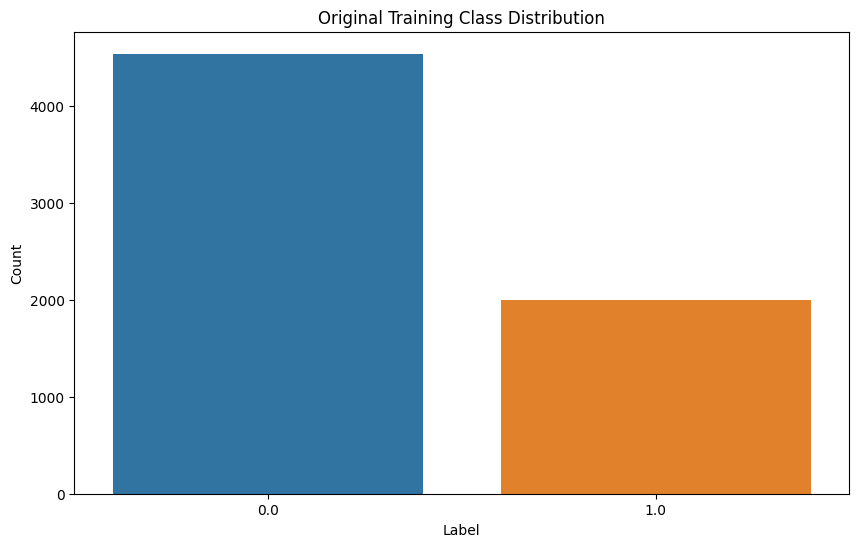

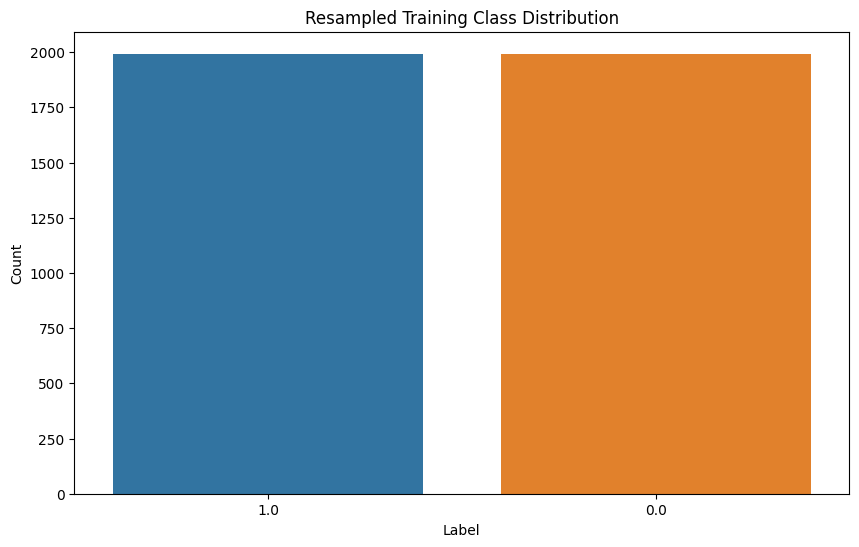

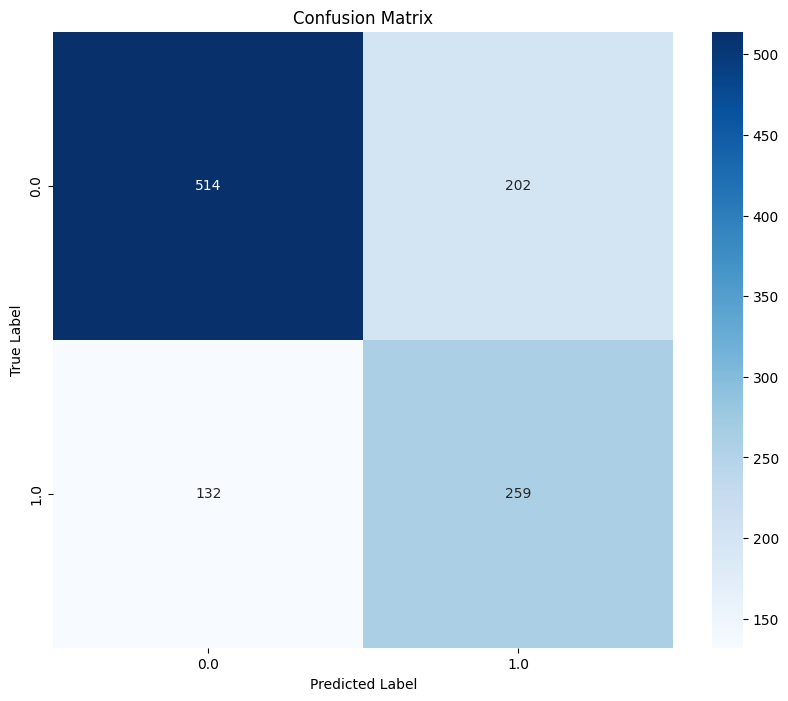

In [21]:
if __name__ == "__main__":
    import os
    
    # File paths for Kaggle notebook
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l2.csv"
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l2.csv"
    model_path = "/kaggle/working/english_text_classifier_l2.joblib"
    
    # Create simple menu-driven interface for Kaggle notebook
    print("\n===== Text Classification Model =====")
    print("1. Train a new model")
    print("2. Load existing model (if available)")
    choice = input("Enter your choice (1/2): ")
    
    model = None
    
    if choice == "1":
        print(f"\nTraining new model with data from {train_file}")
        print(f"Model will be saved to {model_path}")
        
        # Train and evaluate the model
        model, macro_f1, report = train_combined_classifier(train_file, test_file)
        
        # Save the model if training succeeded
        if model is not None:
            save_model(model, model_path)
    
    elif choice == "2":
        if os.path.exists(model_path):
            print(f"\nLoading existing model from {model_path}")
            model = load_model(model_path)
        else:
            print(f"\nNo existing model found at {model_path}")
            print("Please train a new model first.")
    
    # If we have a valid model, provide inference options
    if model is not None:
        while True:
            print("\n===== Inference Options =====")
            print("1. Classify a single text")
            print("2. Classify texts from a CSV file")
            print("3. Run interactive classification")
            print("4. Exit")
            
            inference_choice = input("\nEnter your choice (1/2/3/4): ")
            
            if inference_choice == "1":
                text = input("\nEnter text to classify: ")
                predict_single_text(model, text)
            
            elif inference_choice == "2":
                input_file = input("\nEnter path to input CSV file: ")
                output_file = input("Enter path for output file: ")
                
                # Use Kaggle paths if not specified
                if not input_file:
                    input_file = "/kaggle/input/your-test-dataset/test.csv"
                if not output_file:
                    output_file = "/kaggle/working/predictions.csv"
                
                print(f"\nClassifying texts from {input_file}")
                print(f"Results will be saved to {output_file}")
                predict_on_new_data(model, input_file, output_file)
            
            elif inference_choice == "3":
                interactive_inference(model)
            
            elif inference_choice == "4":
                print("\nExiting the program.")
                break
            
            else:
                print("\nInvalid choice. Please select a valid option.")
    
    print("\n===== End of Program =====")

In [27]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize NLTK components
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to manually undersample a dataset
def manual_undersample(X, y):
    """
    Manually undersample the majority classes to match the minority class.
    
    Args:
        X: Features
        y: Target labels
        
    Returns:
        X_resampled: Undersampled features
        y_resampled: Undersampled target labels
    """
    # Get class counts
    class_counts = Counter(y)
    print(f"Original class distribution: {class_counts}")
    
    # Identify the minority class
    minority_class = min(class_counts, key=class_counts.get)
    min_count = class_counts[minority_class]
    print(f"Minority class: {minority_class}, count: {min_count}")
    
    # Create a dataframe from X and y for easier manipulation
    df = pd.DataFrame({'X': X, 'y': y})
    
    # Initialize the resampled dataframe with all samples from the minority class
    resampled_df = df[df['y'] == minority_class]
    
    # Undersample each majority class
    for cls in class_counts:
        if cls != minority_class:
            # Get samples from the current majority class
            class_df = df[df['y'] == cls]
            
            # Sample the same number as the minority class
            if len(class_df) > min_count:
                sampled_df = class_df.sample(n=min_count, random_state=42)
                resampled_df = pd.concat([resampled_df, sampled_df])
            else:
                # If this class has fewer samples than the minority class, keep all
                resampled_df = pd.concat([resampled_df, class_df])
    
    # Shuffle the resampled dataframe
    resampled_df = resampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Print the new class distribution
    new_class_counts = Counter(resampled_df['y'])
    print(f"Resampled class distribution: {new_class_counts}")
    
    # Return the resampled X and y
    return resampled_df['X'], resampled_df['y']

# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print(f"Sentence Transformer model loaded successfully")

# Custom transformer for Sentence Transformer embeddings
# Fix the SentenceTransformerFeatures transformer
class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Convert to list if not already
        if isinstance(X, pd.Series):
            texts = X.tolist()
        elif isinstance(X, list):
            texts = X  # Already a list
        else:
            texts = [X]  # Single string
            
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            texts, 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings
# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_combined_classifier(train_file, test_file=None):
    """
    Train an English text classifier using SVM with combined Sentence Transformer 
    and Bag of Words features, applying manual undersampling to handle class imbalance.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the original class distribution
        print("\nOriginal training class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot original class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Original Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('original_training_class_distribution.png')
        print("Original class distribution plot saved as 'original_training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Apply manual undersampling to balance classes
        print("\nApplying manual undersampling to balance classes...")
        X_train_resampled, y_train_resampled = manual_undersample(X_train, y_train)
        
        # Print resampled class distribution
        print("\nResampled training class distribution:")
        resampled_class_dist = pd.Series(y_train_resampled).value_counts()
        print(resampled_class_dist)
        
        # Plot resampled class distribution
        resampled_df = pd.DataFrame({'label_class': y_train_resampled})
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=resampled_df)
        plt.title('Resampled Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('resampled_training_class_distribution.png')
        print("Resampled class distribution plot saved as 'resampled_training_class_distribution.png'")
        
        # Create feature union pipeline combining Sentence Transformers and Bag of Words
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...")
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('bag_of_words', Pipeline([
                ('vectorizer', CountVectorizer(
                    max_features=5000,
                    min_df=5,
                    max_df=0.7,
                    stop_words='english'
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=1.0,
                kernel='rbf',  # Radial basis function kernel
                gamma='scale',  # Scale gamma based on feature variance
                # No need for class_weight='balanced' anymore, since we're using undersampling
                probability=True,  # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model on the resampled data
        print("Training the model on resampled data (extracting combined features and fitting SVM)...")
        pipeline.fit(X_train_resampled, y_train_resampled)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(list(set(y_test))), yticklabels=sorted(list(set(y_test))))
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

import joblib

def save_model(model, model_path):
    """
    Save the trained model to disk.
    
    Args:
        model: Trained model pipeline
        model_path: Path to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully!")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model(model_path):
    """
    Load a trained model from disk.
    
    Args:
        model_path: Path to the saved model
        
    Returns:
        Loaded model
    """
    try:
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def predict_single_text(model, text):
    """
    Use a trained model to make a prediction on a single text input.
    
    Args:
        model: Trained classifier pipeline
        text: Text input string
        
    Returns:
        Dictionary containing prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_english_text(text)
        
        # Make prediction (pass as a list)
        prediction_class = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        max_prob = max(probabilities)
        
        # Convert string prediction back to float value
        prediction_value = float(prediction_class)
        
        # Return results
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'predicted_label_class': prediction_class,
            'predicted_label_value': prediction_value,
            'confidence': max_prob
        }
        
        print("\nResults:")
        print(f"Original text: {text}")
        print(f"Processed text: {processed_text}")
        print(f"Prediction (class): {prediction_class}")
        print(f"Prediction (value): {prediction_value}")
        print(f"Confidence: {max_prob:.4f}")
        
        return result
        
    except Exception as e:
        print(f"Error predicting single text: {e}")
        import traceback
        traceback.print_exc()
        return None

def interactive_inference(model):
    """
    Run an interactive session to get predictions on user-provided text.
    
    Args:
        model: Trained classifier pipeline
    """
    print("\n=== Interactive Text Classification ===")
    print("Enter text to classify (or 'q' to quit):")
    
    while True:
        text = input("\nText> ")
        
        if text.lower() == 'q':
            print("Exiting interactive mode.")
            break
            
        if not text.strip():
            print("Please enter some text.")
            continue
            
        result = predict_single_text(model, text)
        
        if result:
            print("\nResults:")
            print(f"Processed text: {result['processed_text']}")
            print(f"Prediction (class): {result['predicted_label_class']}")
            print(f"Prediction (value): {result['predicted_label_value']}")
            print(f"Confidence: {result['confidence']:.4f}")
        else:
            print("Failed to get prediction.")
def run_inference(model, input_source, output_file=None):
    """
    Unified function to run inference on either a file or a single text.
    
    Args:
        model: Trained classifier pipeline
        input_source: Path to CSV file or a single text string
        output_file: Path to save predictions if input is a file
        
    Returns:
        Results dataframe if input is a file, or prediction dict if input is text
    """
    # Check if input_source is a file path
    if os.path.exists(input_source) and input_source.endswith('.csv'):
        print(f"Input is a CSV file: {input_source}")
        return predict_on_new_data(model, input_source, output_file or "predictions.csv")
    else:
        # Treat input_source as a text string
        print("Input is a text string")
        return predict_single_text(model, input_source)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully


In [ ]:
if __name__ == "__main__":
    import os
    
    # File paths for Kaggle notebook
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv"
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv"
    model_path = "/kaggle/working/english_text_classifier_l3.joblib"
    
    # Create simple menu-driven interface for Kaggle notebook
    print("\n===== Text Classification Model =====")
    print("1. Train a new model")
    print("2. Load existing model (if available)")
    choice = input("Enter your choice (1/2): ")
    
    model = None
    
    if choice == "1":
        print(f"\nTraining new model with data from {train_file}")
        print(f"Model will be saved to {model_path}")
        
        # Train and evaluate the model
        model, macro_f1, report = train_combined_classifier(train_file, test_file)
        
        # Save the model if training succeeded
        if model is not None:
            save_model(model, model_path)
    
    elif choice == "2":
        if os.path.exists(model_path):
            print(f"\nLoading existing model from {model_path}")
            model = load_model(model_path)
        else:
            print(f"\nNo existing model found at {model_path}")
            print("Please train a new model first.")
    
    # If we have a valid model, provide inference options
    if model is not None:
        while True:
            print("\n===== Inference Options =====")
            print("1. Classify a single text")
            print("2. Classify texts from a CSV file")
            print("3. Run interactive classification")
            print("4. Exit")
            
            inference_choice = input("\nEnter your choice (1/2/3/4): ")
            
            if inference_choice == "1":
                text = input("\nEnter text to classify: ")
                predict_single_text(model, text)
            
            elif inference_choice == "2":
                input_file = input("\nEnter path to input CSV file: ")
                output_file = input("Enter path for output file: ")
                
                # Use Kaggle paths if not specified
                if not input_file:
                    input_file = "/kaggle/input/your-test-dataset/test.csv"
                if not output_file:
                    output_file = "/kaggle/working/predictions.csv"
                
                print(f"\nClassifying texts from {input_file}")
                print(f"Results will be saved to {output_file}")
                predict_on_new_data(model, input_file, output_file)
            
            elif inference_choice == "3":
                interactive_inference(model)
            
            elif inference_choice == "4":
                print("\nExiting the program.")
                break
            
            else:
                print("\nInvalid choice. Please select a valid option.")
    
    print("\n===== End of Program =====")


===== Text Classification Model =====
1. Train a new model
2. Load existing model (if available)


Enter your choice (1/2):  1



Training new model with data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv
Model will be saved to /kaggle/working/english_text_classifier_l3.joblib
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Original training class distribution:
label_class
0.0    4309
1.0    2222
Name: count, dtype: int64
Original class distribution plot saved as 'original_training_class_distribution.png'

Applying manual undersampling to balance classes...
Original class distribution: Counter({'0.0': 4309, '1.0': 2222})
Minority class: 1.0, count: 2222
Resampled class distribution: Counter({'1.0': 2222, '0.0': 2222})

Resampled training class distribution:
y
1.0    2222
0.0    2222
Name: count, dtype: int64
Resampled class distribution plot saved as 'resampled_training_class_distribution.png'

Creating feature pipeline with Sentence Transformer embeddings, Bag o

Batches:   0%|          | 0/139 [00:00<?, ?it/s]

Model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv...
Preprocessing test text...
Calculating majority vote for test labels...
Making predictions on test data...


Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.7003

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.67      0.74       699
         1.0       0.58      0.76      0.66       408

    accuracy                           0.71      1107
   macro avg       0.70      0.72      0.70      1107
weighted avg       0.74      0.71      0.71      1107

Confusion matrix saved as 'confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'test_predictions.csv'
Saving model to /kaggle/working/english_text_classifier_l3.joblib...
Model saved successfully!

===== Inference Options =====
1. Classify a single text
2. Classify texts from a CSV file
3. Run interactive classification
4. Exit


In [23]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize NLTK components
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to manually undersample a dataset
def manual_undersample(X, y):
    """
    Manually undersample the majority classes to match the minority class.
    
    Args:
        X: Features
        y: Target labels
        
    Returns:
        X_resampled: Undersampled features
        y_resampled: Undersampled target labels
    """
    # Get class counts
    class_counts = Counter(y)
    print(f"Original class distribution: {class_counts}")
    
    # Identify the minority class
    minority_class = min(class_counts, key=class_counts.get)
    min_count = class_counts[minority_class]
    print(f"Minority class: {minority_class}, count: {min_count}")
    
    # Create a dataframe from X and y for easier manipulation
    df = pd.DataFrame({'X': X, 'y': y})
    
    # Initialize the resampled dataframe with all samples from the minority class
    resampled_df = df[df['y'] == minority_class]
    
    # Undersample each majority class
    for cls in class_counts:
        if cls != minority_class:
            # Get samples from the current majority class
            class_df = df[df['y'] == cls]
            
            # Sample the same number as the minority class
            if len(class_df) > min_count:
                sampled_df = class_df.sample(n=min_count, random_state=42)
                resampled_df = pd.concat([resampled_df, sampled_df])
            else:
                # If this class has fewer samples than the minority class, keep all
                resampled_df = pd.concat([resampled_df, class_df])
    
    # Shuffle the resampled dataframe
    resampled_df = resampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Print the new class distribution
    new_class_counts = Counter(resampled_df['y'])
    print(f"Resampled class distribution: {new_class_counts}")
    
    # Return the resampled X and y
    return resampled_df['X'], resampled_df['y']

# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print(f"Sentence Transformer model loaded successfully")

# Custom transformer for Sentence Transformer embeddings
# Fix the SentenceTransformerFeatures transformer
class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Convert to list if not already
        if isinstance(X, pd.Series):
            texts = X.tolist()
        elif isinstance(X, list):
            texts = X  # Already a list
        else:
            texts = [X]  # Single string
            
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            texts, 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings
# Function to calculate majority vote
# Function to calculate majority vote for L1 dataset (add this function)
def majority_vote_l1(row):
    # Extract annotation columns for L1
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

# Function to calculate majority vote for L3 dataset (add this function)
def majority_vote_l3(row):
    # Extract annotation columns for L3
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_combined_classifier(l1_file, l3_file, test_l1_file=None, test_l3_file=None):
    """
    Combine L1 and L3 datasets, train a model, and evaluate.
    Final label is 1 if both L1 and L3 are 1, otherwise 0.
    
    Args:
        l1_file: Path to the L1 CSV file
        l3_file: Path to the L3 CSV file
        test_l1_file: Path to the L1 test CSV file (optional)
        test_l3_file: Path to the L3 test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the L1 CSV file
        print(f"Reading L1 data from {l1_file}...")
        l1_df = pd.read_csv(l1_file, quoting=csv.QUOTE_MINIMAL)
        
        # Read the L3 CSV file
        print(f"Reading L3 data from {l3_file}...")
        l3_df = pd.read_csv(l3_file, quoting=csv.QUOTE_MINIMAL)
        
        # Ensure both datasets have a unique ID to match sentences
        if 'id' not in l1_df.columns:
            l1_df['id'] = range(len(l1_df))
        if 'id' not in l3_df.columns:
            l3_df['id'] = range(len(l3_df))
        
        # Calculate majority vote for L1 dataset
        print("Calculating majority vote for L1 labels...")
        l1_df['l1_label'] = l1_df.apply(majority_vote_l1, axis=1)
        
        # Calculate majority vote for L3 dataset
        print("Calculating majority vote for L3 labels...")
        l3_df['l3_label'] = l3_df.apply(majority_vote_l3, axis=1)
        
        # Extract essential columns from each dataset
        l1_subset = l1_df[['id', 'text', 'l1_label']]
        l3_subset = l3_df[['id', 'l3_label']]
        
        # Merge datasets on ID
        print("Merging L1 and L3 datasets...")
        merged_df = pd.merge(l1_subset, l3_subset, on='id', how='inner')
        
        # Determine final label: 1 if both L1 and L3 are 1, otherwise 0
        merged_df['final_label'] = ((merged_df['l1_label'] == 1.0) & 
                                    (merged_df['l3_label'] == 1.0)).astype(int)
        
        # Preprocess text column
        print("Preprocessing text...")
        merged_df['processed_text'] = merged_df['text'].apply(preprocess_english_text)
        
        # Print the class distribution
        print("\nFinal label class distribution:")
        class_dist = merged_df['final_label'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='final_label', data=merged_df)
        plt.title('Combined Dataset Class Distribution')
        plt.xlabel('Final Label (1 if both L1 and L3 are 1, otherwise 0)')
        plt.ylabel('Count')
        plt.savefig('combined_class_distribution.png')
        print("Class distribution plot saved as 'combined_class_distribution.png'")
        
        # Convert final_label to string to ensure proper handling
        merged_df['label_class'] = merged_df['final_label'].astype(str)
        
        # Prepare training data
        X_train = merged_df['processed_text']
        y_train = merged_df['label_class']
        
        # Apply manual undersampling to balance classes
        print("\nApplying manual undersampling to balance classes...")
        X_train_resampled, y_train_resampled = manual_undersample(X_train, y_train)
        
        # Create feature union pipeline combining Sentence Transformers and Bag of Words
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...")
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('bag_of_words', Pipeline([
                ('vectorizer', CountVectorizer(
                    max_features=5000,
                    min_df=5,
                    max_df=0.7,
                    stop_words='english'
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=1.0,
                kernel='rbf',
                gamma='scale',
                probability=True,
                random_state=42
            ))
        ])
        
        # Train the model on the resampled data
        print("Training the model on resampled data...")
        pipeline.fit(X_train_resampled, y_train_resampled)
        print("Model training complete!")
        
        # If test files are provided, evaluate on them
        if test_l1_file and test_l3_file:
            print(f"\nReading L1 test data from {test_l1_file}...")
            test_l1_df = pd.read_csv(test_l1_file, quoting=csv.QUOTE_MINIMAL)
            
            print(f"Reading L3 test data from {test_l3_file}...")
            test_l3_df = pd.read_csv(test_l3_file, quoting=csv.QUOTE_MINIMAL)
            
            # Ensure both test datasets have a unique ID
            if 'id' not in test_l1_df.columns:
                test_l1_df['id'] = range(len(test_l1_df))
            if 'id' not in test_l3_df.columns:
                test_l3_df['id'] = range(len(test_l3_df))
            
            # Calculate majority vote for test datasets
            test_l1_df['l1_label'] = test_l1_df.apply(majority_vote_l1, axis=1)
            test_l3_df['l3_label'] = test_l3_df.apply(majority_vote_l3, axis=1)
            
            # Extract essential columns from test datasets
            test_l1_subset = test_l1_df[['id', 'text', 'l1_label']]
            test_l3_subset = test_l3_df[['id', 'l3_label']]
            
            # Merge test datasets
            merged_test_df = pd.merge(test_l1_subset, test_l3_subset, on='id', how='inner')
            
            # Determine final test label
            merged_test_df['final_label'] = ((merged_test_df['l1_label'] == 1.0) & 
                                           (merged_test_df['l3_label'] == 1.0)).astype(int)
            
            # Preprocess test text
            merged_test_df['processed_text'] = merged_test_df['text'].apply(preprocess_english_text)
            
            # Convert to string class labels to match training data
            merged_test_df['label_class'] = merged_test_df['final_label'].astype(str)
            
            # Print test class distribution
            print("\nTest data class distribution:")
            test_class_dist = merged_test_df['final_label'].value_counts()
            print(test_class_dist)
            
            # Prepare test data
            X_test = merged_test_df['processed_text']
            y_test = merged_test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save test predictions
            results_df = pd.DataFrame({
                'id': merged_test_df['id'],
                'text': X_test.values,
                'l1_label': merged_test_df['l1_label'],
                'l3_label': merged_test_df['l3_label'],
                'true_combined_label': merged_test_df['final_label'],
                'predicted_label': y_pred,
                'probability_class_1': pipeline.predict_proba(X_test)[:, 1] if '1' in pipeline.classes_ else [0]*len(y_pred)
            })
            results_df.to_csv('combined_test_predictions.csv', index=False)
            print("Test predictions saved to 'combined_test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test files provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

import joblib

def save_model(model, model_path):
    """
    Save the trained model to disk.
    
    Args:
        model: Trained model pipeline
        model_path: Path to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully!")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model(model_path):
    """
    Load a trained model from disk.
    
    Args:
        model_path: Path to the saved model
        
    Returns:
        Loaded model
    """
    try:
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def predict_single_text(model, text):
    """
    Use a trained model to make a prediction on a single text input.
    
    Args:
        model: Trained classifier pipeline
        text: Text input string
        
    Returns:
        Dictionary containing prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_english_text(text)
        
        # Make prediction (pass as a list)
        prediction_class = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        max_prob = max(probabilities)
        
        # Convert string prediction back to float value
        prediction_value = float(prediction_class)
        
        # Return results
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'predicted_label_class': prediction_class,
            'predicted_label_value': prediction_value,
            'confidence': max_prob
        }
        
        print("\nResults:")
        print(f"Original text: {text}")
        print(f"Processed text: {processed_text}")
        print(f"Prediction (class): {prediction_class}")
        print(f"Prediction (value): {prediction_value}")
        print(f"Confidence: {max_prob:.4f}")
        
        return result
        
    except Exception as e:
        print(f"Error predicting single text: {e}")
        import traceback
        traceback.print_exc()
        return None

def interactive_inference(model):
    """
    Run an interactive session to get predictions on user-provided text.
    
    Args:
        model: Trained classifier pipeline
    """
    print("\n=== Interactive Text Classification ===")
    print("Enter text to classify (or 'q' to quit):")
    
    while True:
        text = input("\nText> ")
        
        if text.lower() == 'q':
            print("Exiting interactive mode.")
            break
            
        if not text.strip():
            print("Please enter some text.")
            continue
            
        result = predict_single_text(model, text)
        
        if result:
            print("\nResults:")
            print(f"Processed text: {result['processed_text']}")
            print(f"Prediction (class): {result['predicted_label_class']}")
            print(f"Prediction (value): {result['predicted_label_value']}")
            print(f"Confidence: {result['confidence']:.4f}")
        else:
            print("Failed to get prediction.")
def run_inference(model, input_source, output_file=None):
    """
    Unified function to run inference on either a file or a single text.
    
    Args:
        model: Trained classifier pipeline
        input_source: Path to CSV file or a single text string
        output_file: Path to save predictions if input is a file
        
    Returns:
        Results dataframe if input is a file, or prediction dict if input is text
    """
    # Check if input_source is a file path
    if os.path.exists(input_source) and input_source.endswith('.csv'):
        print(f"Input is a CSV file: {input_source}")
        return predict_on_new_data(model, input_source, output_file or "predictions.csv")
    else:
        # Treat input_source as a text string
        print("Input is a text string")
        return predict_single_text(model, input_source)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully



===== Text Classification Model =====
1. Train a new model
2. Load existing model (if available)


Enter your choice (1/2):  1



Training new model with data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv
Model will be saved to /kaggle/working/english_text_classifier_task3.joblib
Reading L1 data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv...
Reading L3 data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv...
Calculating majority vote for L1 labels...
Calculating majority vote for L3 labels...
Merging L1 and L3 datasets...
Preprocessing text...

Final label class distribution:
final_label
0    5400
1    1131
Name: count, dtype: int64
Class distribution plot saved as 'combined_class_distribution.png'

Applying manual undersampling to balance classes...
Original class distribution: Counter({'0': 5400, '1': 1131})
Minority class: 1, count: 1131
Resampled class distribution: Counter({'0': 1131, '1': 1131})

Creating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...
Training the model on resampled data...


Batches:   0%|          | 0/71 [00:00<?, ?it/s]

Model training complete!

Reading L1 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv...
Reading L3 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv...

Test data class distribution:
final_label
0    911
1    196
Name: count, dtype: int64
Making predictions on test data...


Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6800

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.85       911
           1       0.41      0.70      0.51       196

    accuracy                           0.77      1107
   macro avg       0.66      0.74      0.68      1107
weighted avg       0.83      0.77      0.79      1107

Confusion matrix saved as 'confusion_matrix.png'


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Test predictions saved to 'combined_test_predictions.csv'
Saving model to /kaggle/working/english_text_classifier_task3.joblib...
Model saved successfully!

===== Inference Options =====
1. Classify a single text
2. Classify texts from a CSV file
3. Run interactive classification
4. Exit


KeyboardInterrupt: Interrupted by user

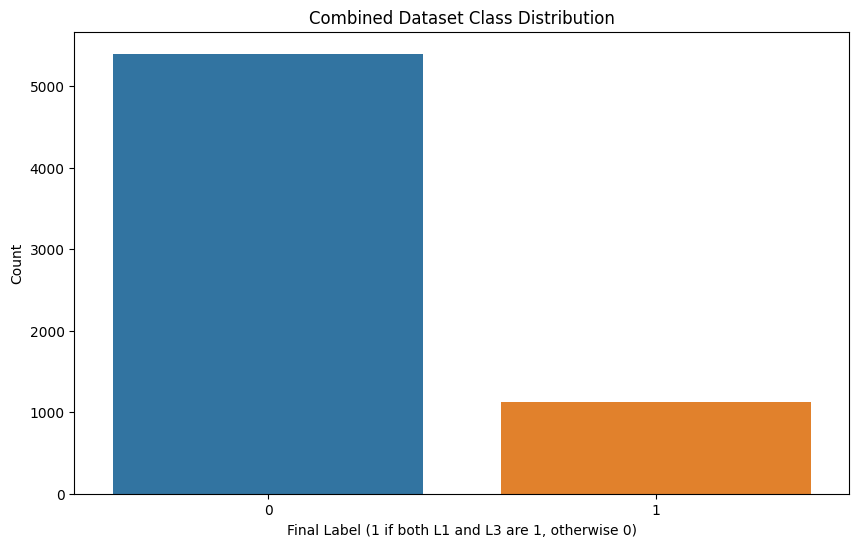

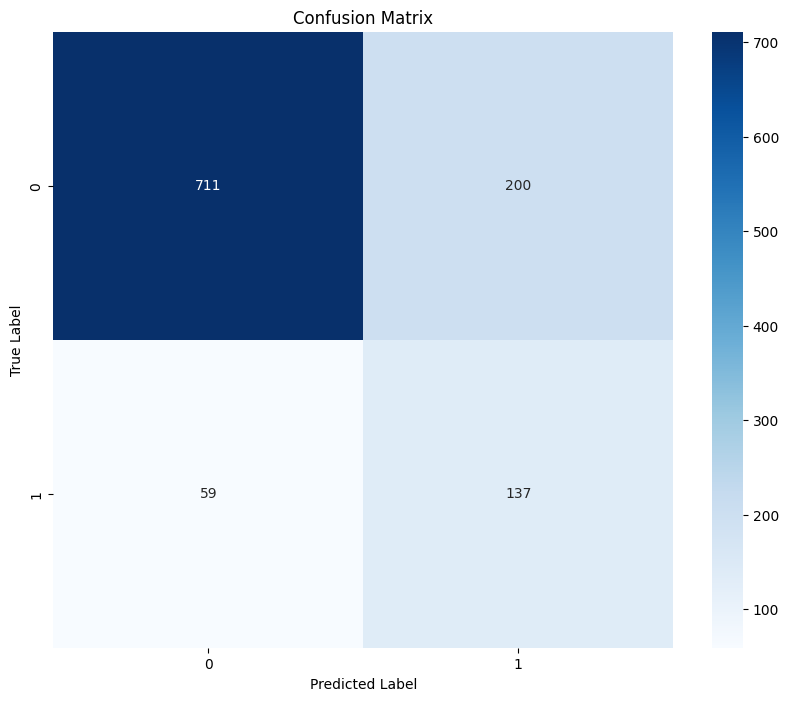

In [26]:
if __name__ == "__main__":
    import os
    l1_train_file='/kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv'
    l3_train_file='/kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv'
    l1_test_file='/kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv'
    l3_test_file='/kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv'
    model_path = "/kaggle/working/english_text_classifier_task3.joblib"
    

    
    # Create simple menu-driven interface for Kaggle notebook
    print("\n===== Text Classification Model =====")
    print("1. Train a new model")
    print("2. Load existing model (if available)")
    choice = input("Enter your choice (1/2): ")
    
    model = None
    
    if choice == "1":
        print(f"\nTraining new model with data from {train_file}")
        print(f"Model will be saved to {model_path}")
        
        # Train and evaluate the model
        model, f1, report = train_combined_classifier(l1_train_file, l3_train_file, l1_test_file, l3_test_file)
        
        # Save the model if training succeeded
        if model is not None:
            save_model(model, model_path)
    
    elif choice == "2":
        if os.path.exists(model_path):
            print(f"\nLoading existing model from {model_path}")
            model = load_model(model_path)
        else:
            print(f"\nNo existing model found at {model_path}")
            print("Please train a new model first.")
    
    # If we have a valid model, provide inference options
    if model is not None:
        while True:
            print("\n===== Inference Options =====")
            print("1. Classify a single text")
            print("2. Classify texts from a CSV file")
            print("3. Run interactive classification")
            print("4. Exit")
            
            inference_choice = input("\nEnter your choice (1/2/3/4): ")
            
            if inference_choice == "1":
                text = input("\nEnter text to classify: ")
                predict_single_text(model, text)
            
            elif inference_choice == "2":
                input_file = input("\nEnter path to input CSV file: ")
                output_file = input("Enter path for output file: ")
                
                # Use Kaggle paths if not specified
                if not input_file:
                    input_file = "/kaggle/input/your-test-dataset/test.csv"
                if not output_file:
                    output_file = "/kaggle/working/predictions.csv"
                
                print(f"\nClassifying texts from {input_file}")
                print(f"Results will be saved to {output_file}")
                predict_on_new_data(model, input_file, output_file)
            
            elif inference_choice == "3":
                interactive_inference(model)
            
            elif inference_choice == "4":
                print("\nExiting the program.")
                break
            
            else:
                print("\nInvalid choice. Please select a valid option.")
    
    print("\n===== End of Program =====")